In [ ]:
# This notebook can be used to plot our results for the integrated cross section analysis.
# Prerequisites:
# 1) "Perfect" gaussian NuWro files,
# NuWro/test"+locstring+"l"+widthstring+"w/flat_test"+locstring+"l"+widthstring+"w_Ar_SF_numu_NuWroOut_"+str(seeds[width][loc])+".root
# And see the relevant block for more details on the format
# 2) Thin gaussian NuWro generated .root files, same format
# 3) Full set of toys with E_recoil < 4 GeV in the format of a numpy array with shape (N_toys, 58 off-axis bins, 16000 energy bins)
# 4) Prepared results without the E_recoil cut, with shape (3,7) where in the 0 axis,
# res[0] = measurement
# res[1] = uncertainty (stat+shape)
# res[2] = uncertainty (shape only)
# Actually 4) is by no mean necessary, one could compute this on the go. The limitations of the SWAN configurations in terms of cached memory made it
# impossible to load 2 sets of toys in the same sessions so I had to resort to precalculating the results. You could do this calculation using the exact same
# code here with simple modifications. In any case the code I used to do this is in ToysROOTtoNumpy.ipynb.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from ipynb.fs.full.CoefficientsCalcPlus import GetCoefficientsFlux
from ipynb.fs.full.CoefficientsCalcPlus import get_normalization
import sklearn.linear_model as linear_model
import scipy
import warnings; warnings.simplefilter('ignore')
import os
import re
from matplotlib.pyplot import figure
import random as rnd
import matplotlib.ticker as ticker
#import cvxpy as cp
import uproot4 as uproot
import scipy.stats
import seaborn as sns
import ROOT
from scipy.interpolate import make_interp_spline

Welcome to JupyROOT 6.30/04


In [14]:
# Helper functions

def get_normalization(coeffs):
    with uproot.open("/eos/home-a/amgruber/SWAN_projects/DUNEPRISM_XSec_SDClone_EditedVersion/Fluxes.ND.root") as fFluxes :
        oa_flux = fFluxes['LBNF_numu_flux'].values()
        energy_bins = fFluxes['LBNF_numu_flux'].axis(0).edges() # in GeV
        angle_bins = fFluxes['LBNF_numu_flux'].axis(1).edges() # in milliradians
    oa_flux = oa_flux.transpose()
    first_bin_flux = 8.9769702e-08
    norm = (oa_flux[0].sum()*0.01)/first_bin_flux
    oa_flux = oa_flux/norm
    print(oa_flux[0].sum()*0.01)
    oa_flux = oa_flux.transpose()
    lin_combo = np.matmul(oa_flux, coeffs)
    return lin_combo.sum()*0.01

def get_normalization_cutoff(coeffs,cutoff):
    # Cutoff in GeV
    cutoff_bin = int(cutoff*(800/8))
    with uproot.open("/eos/home-a/amgruber/SWAN_projects/DUNEPRISM_XSec_SDClone_EditedVersion/Fluxes.ND.root") as fFluxes :
        oa_flux = fFluxes['LBNF_numu_flux'].values()
        energy_bins = fFluxes['LBNF_numu_flux'].axis(0).edges() # in GeV
        angle_bins = fFluxes['LBNF_numu_flux'].axis(1).edges() # in milliradians
    oa_flux = oa_flux.transpose()
    first_bin_flux = 8.9769702e-08
    norm = (oa_flux[0].sum()*0.01)/first_bin_flux
    oa_flux = oa_flux/norm
    print(oa_flux[0].sum()*0.01)
    oa_flux = oa_flux.transpose()
    lin_combo = np.matmul(oa_flux, coeffs)
    return np.sum(lin_combo[:cutoff_bin])*0.01

def get_gaussian_std(prediction,energy_bin_centers,oa_events):
    gfit = optimize.curve_fit(gaussian,energy_bin_centers,prediction)[0]
    loc,scale = gfit[0],gfit[1]
    return [scale,loc]

def gaussian(x,loc,scale):
    return (1/(scale*((2*np.pi)**0.5)))*np.exp((-((x-loc)/scale)**2)/2)*rescaling

def get_virtual_flux(energy,width,plot=True,alpha=1e-12):
    # Get DUNE near detector muon neutrino flux as a function of off-axis angle
    with uproot.open("Fluxes.ND.root") as fFluxes :
        oa_flux = fFluxes['LBNF_numu_flux'].values()
        energy_bins = fFluxes['LBNF_numu_flux'].axis(0).edges() # in GeV
        angle_bins = fFluxes['LBNF_numu_flux'].axis(1).edges() # in milliradians

    N_target = 1.435e30 #[nucleon]
    E = 3.62e19 #[POT per year]
    epsilon = 1

    target_loc = 1e-3*energy
    target_scale = 1e-3*width
    rescaling = oa_flux.max()
    print(rescaling)
    energy_bin_centers = np.add(energy_bins[:-1], energy_bins[1:])/2.
    target_flux = [scipy.stats.norm.pdf(x, loc = target_loc, scale = target_scale)*rescaling for x in energy_bin_centers] #here we should scale the gaussian

    clf = linear_model.Ridge(alpha=alpha,fit_intercept=False) #when fit_intercept=False OA(dot)x = predict(x)
    clf.fit(oa_flux,target_flux)
    x_ridge = clf.coef_

    if plot==True:
        #figure(figsize=(8, 6))
        plt.plot(energy_bin_centers, target_flux, label = "Target Flux")
        plt.plot(energy_bin_centers, clf.predict(oa_flux), label = "Virtual Flux")
        plt.xlabel(r"E$_{\nu}$ [GeV]")
        #plt.xlim([0, 1.5])

        plt.legend();
        plt.grid(True, color = "grey", linewidth = "1", linestyle = "-")
        plt.show()
    
    return energy_bin_centers, clf.predict(oa_flux)

def shift(toy,energy):
    toy = np.roll(toy,energy,axis=-1)
    toy[..., -energy:] = 0
    return toy

In [2]:
# Fetch 70 MeV gaussian cross section (using fScaleFactor, which is a NuWro output)
# Seeds are required using the naming convention we used in our NuWro-generated .root files and should be updated manually

seeds = {0.07:{0.5:30288,0.75:16134,1:29554,1.25:23129,1.5:22920,1.75:22516,2:25490},0.1:{0.5:28604,0.75:17160,1:12196,1.25:29728,1.5:19473},0.078:{0.75:27454}}
loc = 0.75
width = 0.078
locstring = str(loc).replace(".","")
widthstring = str(width).replace(".","")
xsecs = {}
for width in seeds:
    xsecs[width] = {}
    for loc in seeds[width]:
        locstring = str(loc).replace(".","")
        widthstring = str(width).replace(".","")
        file = ROOT.TFile.Open("NuWro/test"+locstring+"l"+widthstring+"w/flat_test"+locstring+"l"+widthstring+"w_Ar_SF_numu_NuWroOut_"+str(seeds[width][loc])+".root")
        t = file.Get("FlatTree_VARS")
        for event in t:
            xsecs[width][loc] = 1e6*event.fScaleFactor
            break
        file.Close()

vals = [xsecs[0.07][x] for x in xsecs[0.07].keys()]
locs = xsecs[0.07].keys()

In [3]:
# Load the (N_toys, 58 off-axis bins, 16000 energy bins) numpy array which contains the full set of toys required for simulating the uncertainties

full_res = np.load("../FluxTest/NumpyOmega4000CutFixed/FullResults.npy")

In [4]:
# Calculate cross sections based on full_res 

xsec = []
dxsec_sys = []
dxsec_stat = []
energies = np.array([1e3*loc for loc in locs])
denergies = [] # Gaussian widths
sys_results = []
stat_results = []
years = 5

full_res_cv_total = full_res.mean(axis=0).sum(axis=1)
res_stat = np.array([np.random.poisson(years*full_res_cv_total) for i in range(1000)])

for energy in energies:
    alpha = 1e-12
    coeffs, std = GetCoefficientsFlux(1e-3*energy,0.07,alpha,model=linear_model.Ridge,years=1)
    norm = get_normalization(coeffs)
    
    # Normalization
    rebin_factor = 1
    E = (12/201)*1.1e21
    nucleons = 1.3954*(2*3*0.574)*1e3/1.66e-27
    ftilde = 1e38*(1/(E*nucleons*get_normalization_cutoff(coeffs,4)))/(1e-3*rebin_factor)
    
    denergies.append(1e3*std)
    
    ## Sys
    expanded_coeffs = np.expand_dims(coeffs, axis=1)
    result = full_res * expanded_coeffs
    result = np.sum(result, axis=1)
    sys_result = np.sum(result, axis=1)
    sys_results.append(sys_result)
    
    xsec.append((ftilde*sys_result).mean()*0.001)
    
    ## Stat
    temp_res = res_stat @ expanded_coeffs
    stat_result = temp_res * ftilde * 0.001 / years
    stat_results.append(np.squeeze(stat_result,axis=1))

sys_results = np.array(sys_results)
stat_results = np.array(stat_results)

Gaussian width: 0.07761638542303777
8.976970200000002e-08
8.976970200000002e-08
Gaussian width: 0.0780297442452165
8.976970200000002e-08
8.976970200000002e-08
Gaussian width: 0.09192501630780707
8.976970200000002e-08
8.976970200000002e-08
Gaussian width: 0.10728030216086437
8.976970200000002e-08
8.976970200000002e-08
Gaussian width: 0.12657999085130975
8.976970200000002e-08
8.976970200000002e-08
Gaussian width: 0.16084543429651912
8.976970200000002e-08
8.976970200000002e-08
Gaussian width: 0.18984600156997525
8.976970200000002e-08
8.976970200000002e-08


In [6]:
cv = np.array(xsec)
true = 1e38*np.array(vals)
if energies[0] == 500:
    energies = np.array([1e-3*energy for energy in energies])
    denergies = np.array([1e-3*denergy for denergy in denergies])

## Systematics, using Norm-Shape decomposition
sys_results_t = sys_results.T # Shape: [#toys, #energies]
row_sums = np.sum(sys_results_t, axis=1)
expanded_sums = np.expand_dims(row_sums, axis=1)
sys_results_normed = sys_results_t / expanded_sums
sys_results_normed[:,-1] = np.array(row_sums)

cov_test = np.cov(sys_results_normed.T)
sums_mean = sys_results.T.sum(axis=1).mean()
shape = np.sqrt(cov_test.diagonal()[:-1])/(sys_results_normed.T[:-1,:].mean(axis=1))
shape_unc = np.abs(cv*np.append(shape,0))
norm_unc = cv*np.sqrt(cov_test[-1,-1])/sums_mean

## Statistics
stat_unc = np.sqrt(np.diagonal(np.cov(stat_results)))

## Stat + Shape
stat_shape_unc = np.sqrt(stat_unc**2+shape_unc**2)

## By the end of this block, cv = reco; centers = x axis; shape_unc and norm_unc are the decomposed uncertainties

deco_cov = np.cov(sys_results_normed.T)

In [8]:
# Get true cross section, based on thin fluxes (effectively 0.0001 GeV width gaussians)

thin_fluxes_path = "NuWro/"

def process_flat_file(file_path):
    values = []
    file = ROOT.TFile.Open(file_path, "READ")
    t = file.Get("FlatTree_VARS")
    for event in t:
        values.append(1e38 * 1e6 * event.fScaleFactor)
        break
    file.Close()
    return values

def convert_folder_name_to_float(folder_name):
    digits = re.search(r'test(\d+)', folder_name).group(1)
    return float(f"{digits[0]}.{digits[1:]}")

def collect_values(target_directory):
    all_values = []
    folder_floats = []
    for item in os.listdir(target_directory):
        item_path = os.path.join(target_directory, item)
        if os.path.isdir(item_path) and re.match(r'test\d+', item):
            folder_float = convert_folder_name_to_float(item)
            folder_floats.append(folder_float)
            for file in os.listdir(item_path):
                if file.startswith('flat'):
                    flat_file_path = os.path.join(item_path, file)
                    all_values.extend(process_flat_file(flat_file_path))
                    break
    return all_values, folder_floats

target_directory = thin_fluxes_path+'ThinFluxes'  # Change this to your target directory
all_values, folder_floats = collect_values(target_directory)

true_thin = [all_values[folder_floats.index(val)] for val in energies]

# Spline between datapoints
energy_spline = np.linspace(np.array(folder_floats).min(), np.array(folder_floats).max(), 1000)
true_spline = make_interp_spline(folder_floats, all_values)(energy_spline)

In [10]:
# Get integrated result with no cut

nocutres = np.load('../FluxTest/IntegratedNoCutRes.npy')
xsec_nocut = nocutres[0]
dxsec_stat_shape_nocut = nocutres[1]
dxsec_shape_nocut = nocutres[2]

9.233599406904768e-06
9.233599406904768e-06
9.233599406904768e-06
9.233599406904768e-06
9.233599406904768e-06
9.233599406904768e-06
9.233599406904768e-06


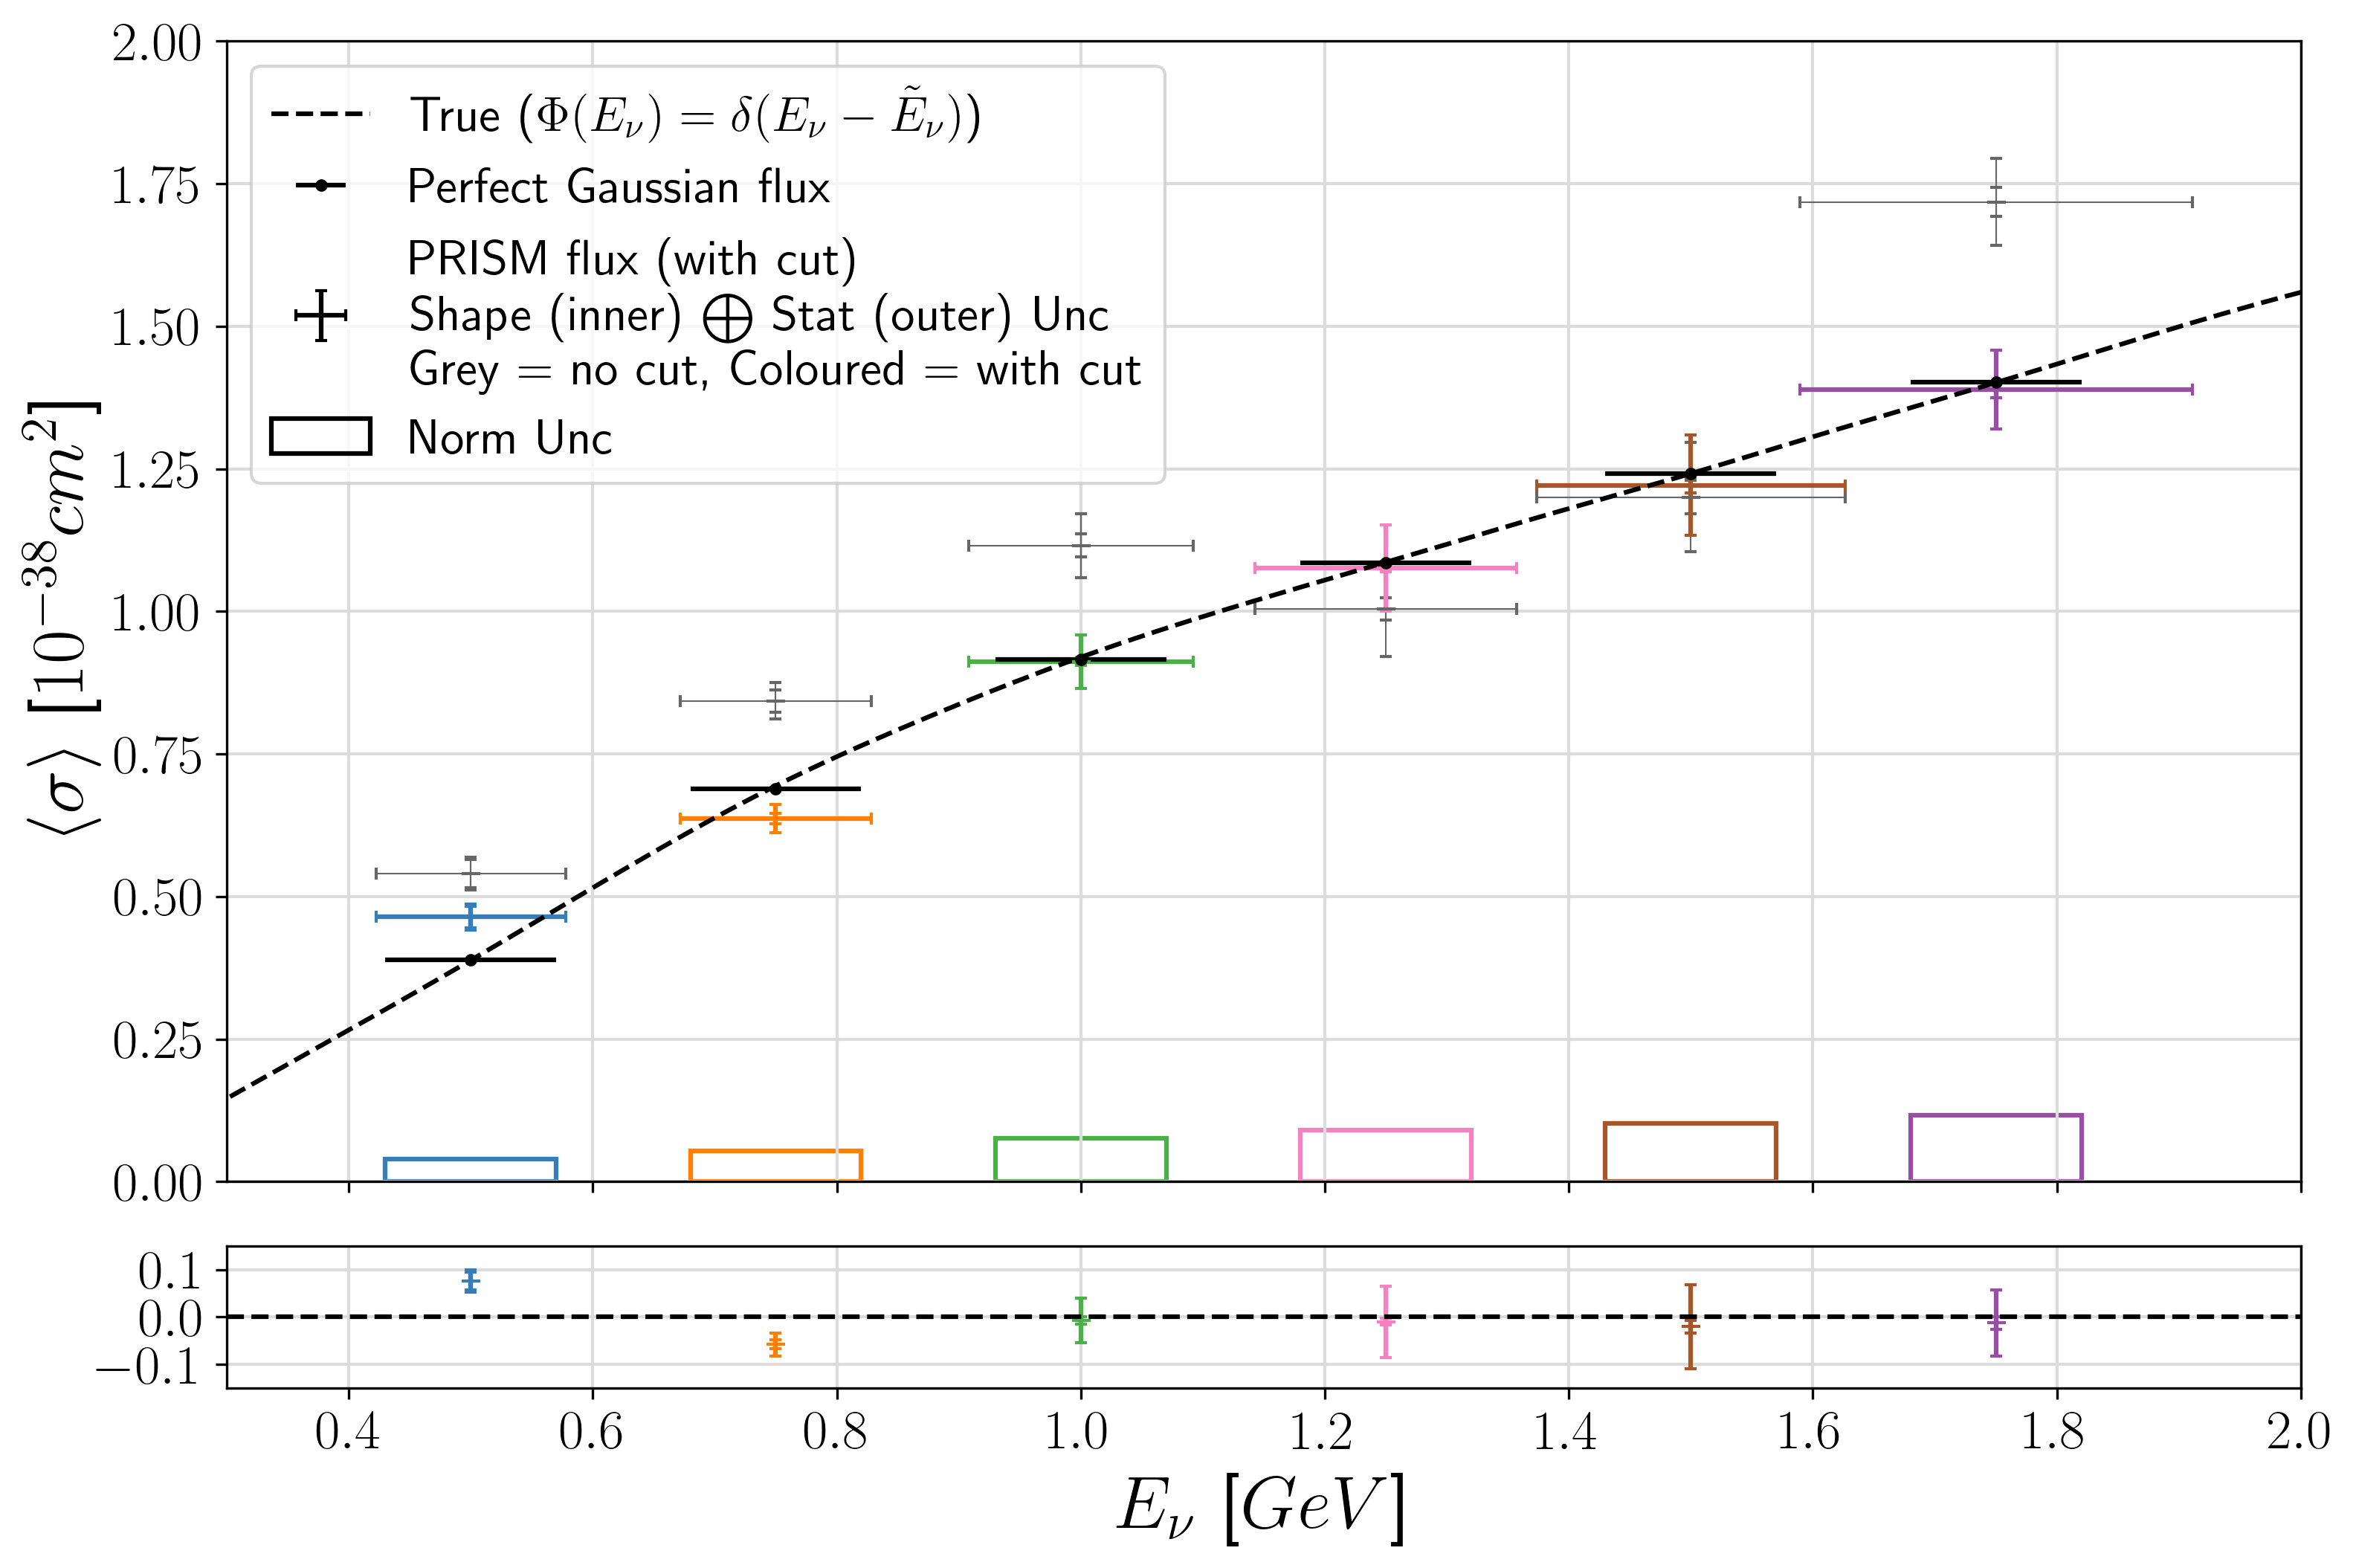

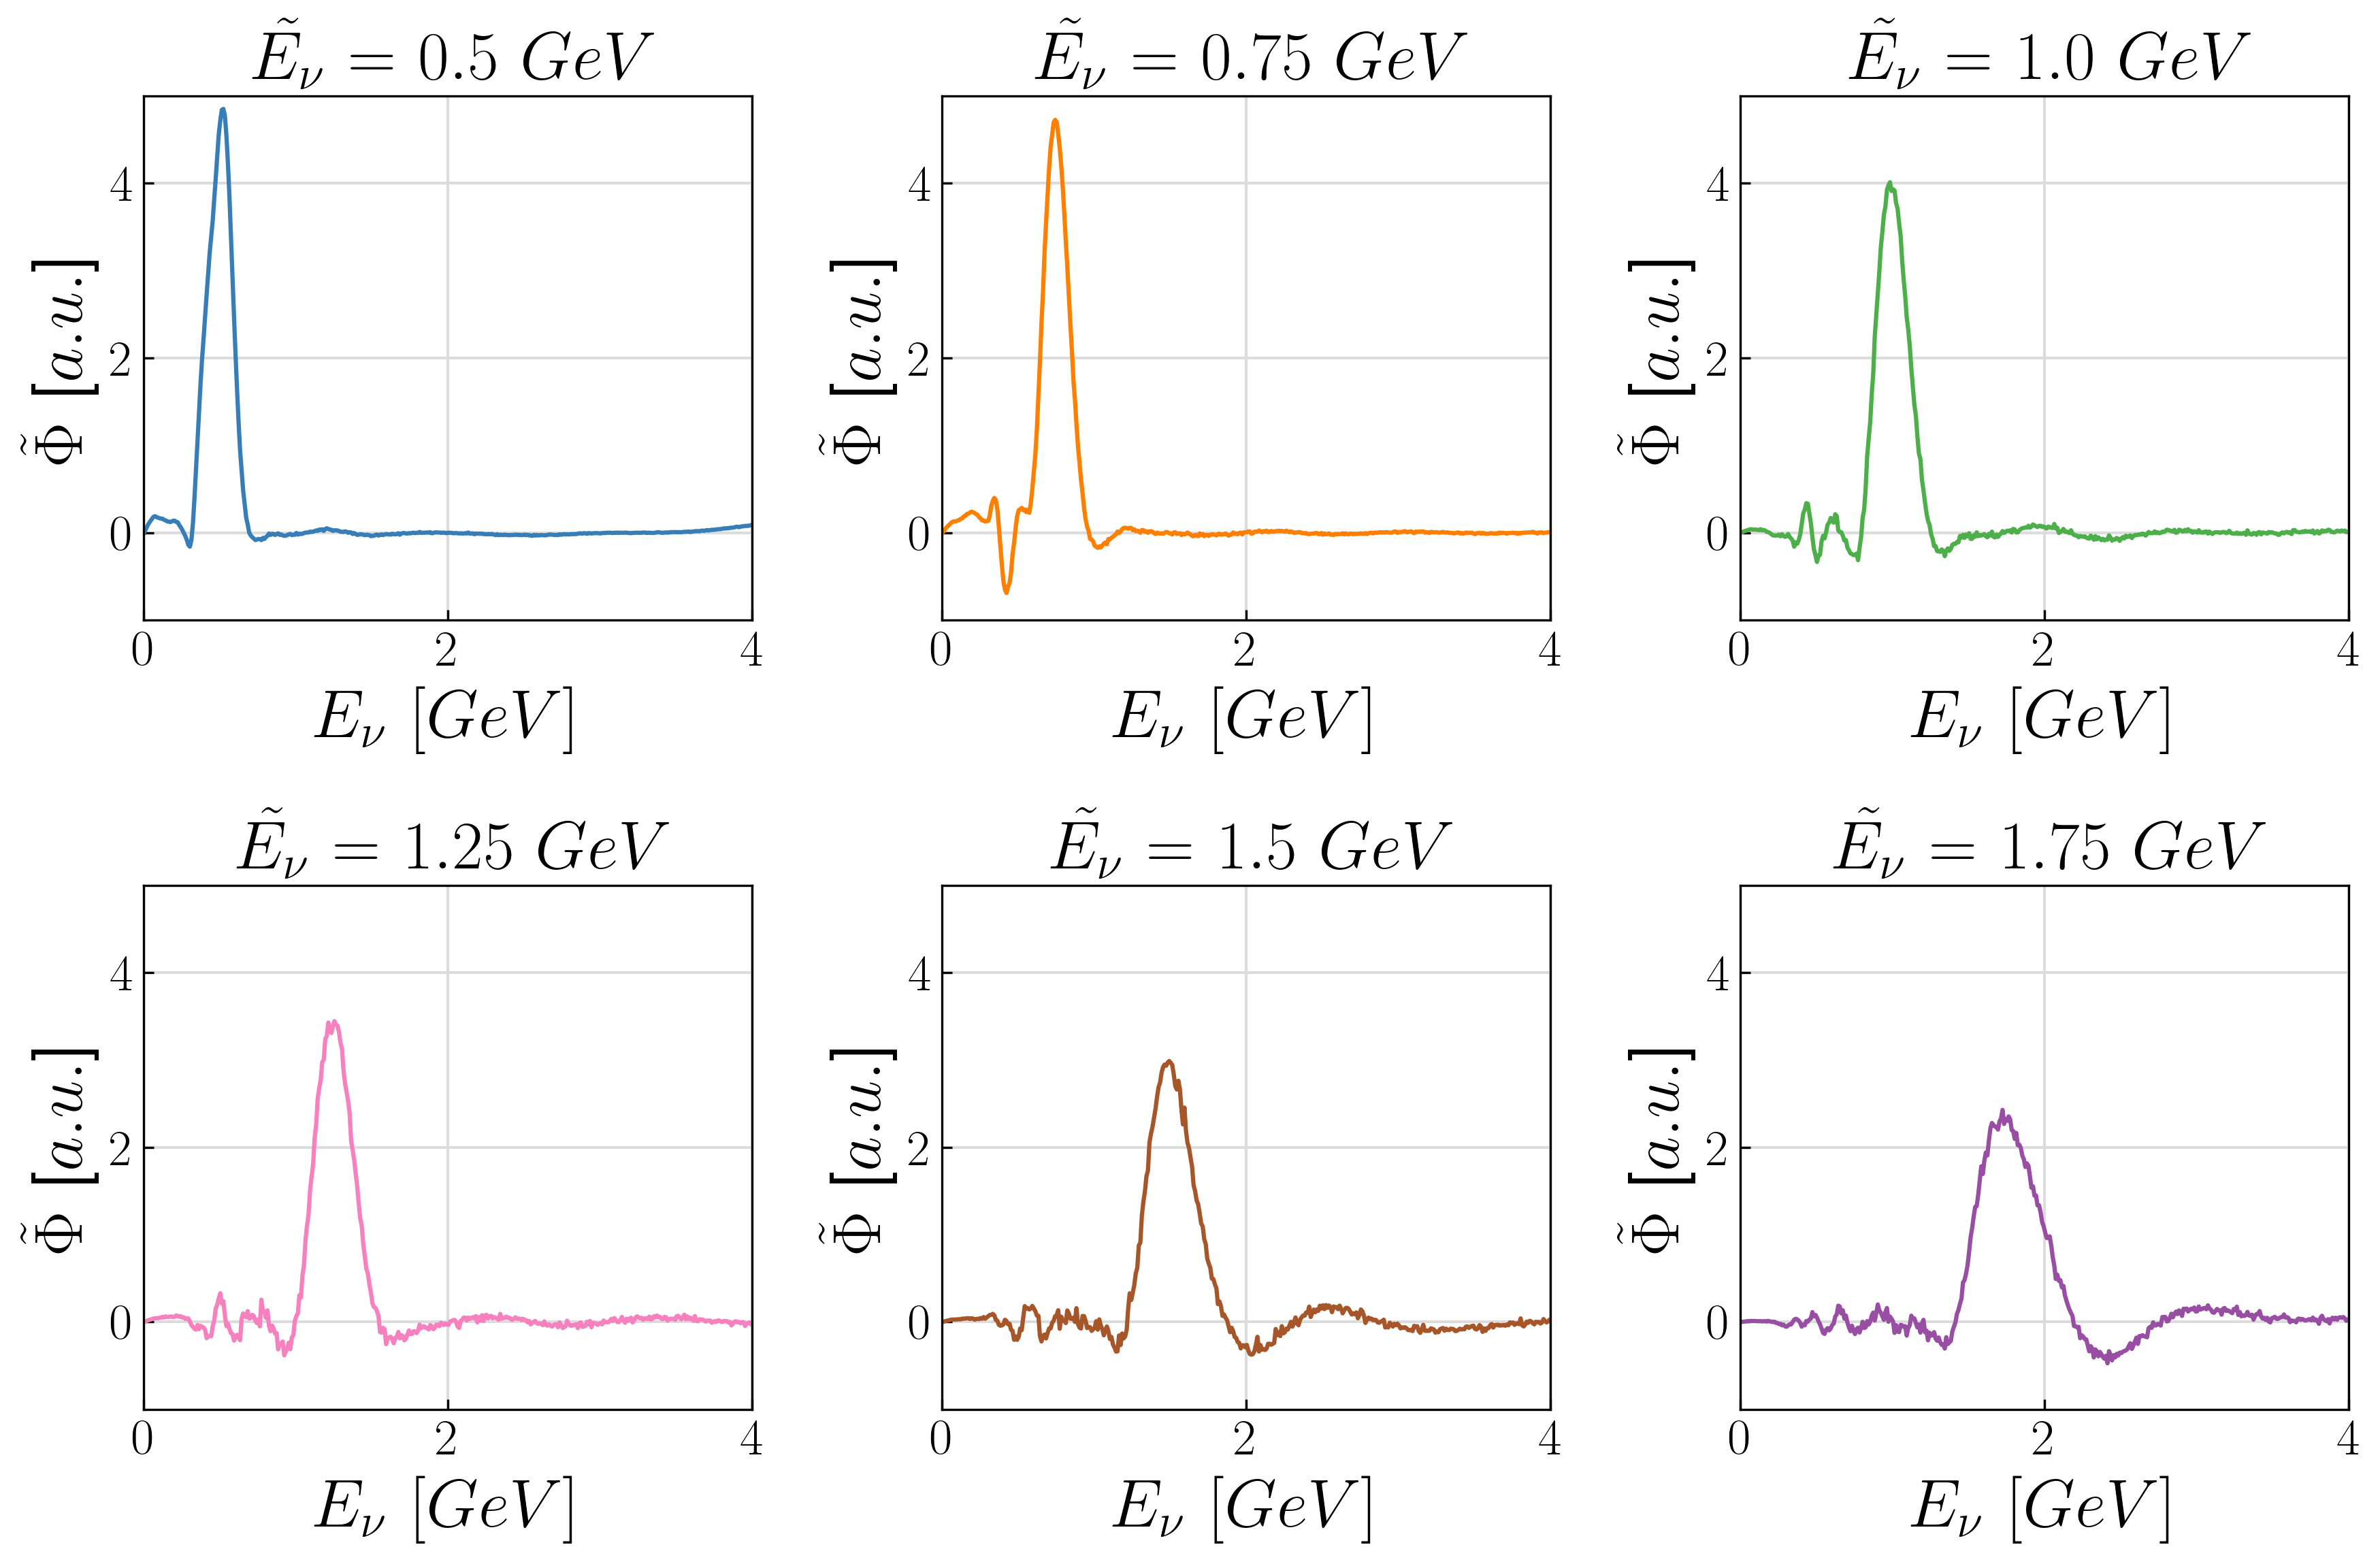

In [15]:
plt.rcParams['text.usetex'] = True
plt.rcParams['font.size'] = 18
fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(12, 8), gridspec_kw={'height_ratios': [8, 1]}, dpi=300)
plt.gcf().set_facecolor('white')
plt.grid()

residuals = -(true_thin - cv)

col = 'mediumvioletred'
colors = ['#377eb8',  # Blue
          '#ff7f00',  # Orange
          '#4daf4a',  # Green
          '#f781bf',  # Pink
          '#a65628',  # Brown
          '#984ea3',  # Purple
          '#999999',  # Gray
          '#e41a1c',  # Red
          '#dede00']  # Yellow
lwidth = 1.5

## Plot no cut
nocutcolor = str(0.4)
ax1.errorbar(energies[:-1],xsec_nocut[:-1],xerr=denergies[:-1],yerr=dxsec_stat_shape_nocut[:-1],color=nocutcolor,fmt='_', linewidth=0.5, capsize=2, capthick=1,ecolor=nocutcolor)
ax1.errorbar(energies[:-1],xsec_nocut[:-1],yerr=dxsec_shape_nocut[:-1], color=nocutcolor, fmt=' ', linewidth=0.5, capsize=2, capthick=1, ecolor=nocutcolor)

##
legend_label = 'PRISM flux (with cut) \n Shape (inner) $\\bigoplus$ Stat (outer) Unc \n Grey = no cut, Coloured = with cut'
ax1.errorbar([0],[0],xerr=[0],yerr=[0],color='black',fmt='_',label=legend_label, linewidth=lwidth, capsize=2, capthick=1,ecolor='black')
ax1.errorbar([0],[0],xerr=[0],yerr=[0], color='black', fmt=' ', linewidth=lwidth, capsize=2, capthick=1, ecolor='black')
for i in range(len(energies)-1):
    legend_label = ""
    ax1.errorbar(energies[:-1][i],cv[:-1][i],xerr=denergies[:-1][i],yerr=stat_shape_unc[:-1][i],color=colors[i],fmt='_',label=legend_label, linewidth=lwidth, capsize=2, capthick=1,ecolor=colors[i])
    ax1.errorbar(energies[:-1][i],cv[:-1][i],yerr=shape_unc[:-1][i], color=colors[i], fmt=' ', linewidth=lwidth, capsize=2, capthick=1, ecolor=colors[i])
    ax2.errorbar(energies[:-1][i], residuals[:-1][i], yerr=stat_shape_unc[:-1][i], color=colors[i], fmt='_', linewidth=lwidth, capsize=2, capthick=1,ecolor=colors[i])
    ax2.errorbar(energies[:-1][i], residuals[:-1][i], yerr=shape_unc[:-1][i], color=colors[i], fmt=' ', linewidth=lwidth, capsize=2, capthick=1,ecolor=colors[i])
##

ax1.errorbar(energies[:-1],true[:-1],xerr=[0.07 for i in range(len(true[:-1]))],fmt='.',color='black',label='Perfect Gaussian flux')
bar_width = 0.14
bar_legend_label = r"Norm Unc"
ax1.bar([0],[0],label=bar_legend_label,width=bar_width, linewidth=lwidth, edgecolor='black', color='none')
for i in range(len(energies)-1):
    bar_legend_label = ""
    ax1.bar(energies[i],norm_unc[i],label=bar_legend_label,width=bar_width, linewidth=lwidth, edgecolor=colors[i], color='none')

ax1.plot(energy_spline,true_spline,color='black',linestyle='--',label=r'True ($\Phi(E_{\nu}) = \delta(E_{\nu}-\tilde{E}_{\nu})$)')
ax1.set_xlim(0.3,2)
ax1.set_ylim(0,2.)
ax1.set_ylabel("$\langle \\sigma \\rangle$ [$10^{-38}cm^{2}$]",fontsize=24)

ax2.axhline(y=0, color='black',linestyle='--')
ax2.set_ylim(-0.15,0.15)
ax1.grid(True, color = "gainsboro", linewidth = "1", linestyle = "-")
ax2.grid(True, color = "gainsboro", linewidth = "1", linestyle = "-")
ax2.set_xlabel("$E_{\\nu}$ [$GeV$]",fontsize=24)

handles, labels = ax1.get_legend_handles_labels()
order = [0, 2, 1, 3]
legend = ax1.legend([handles[idx] for idx in order], [labels[idx] for idx in order],fontsize=16)

plt.subplots_adjust(hspace=0.1)

# Virtual fluxes

# Generate a 3x2 grid of subplots
fig, axs = plt.subplots(2, 3, figsize=(12, 8), dpi=300)  # Adjust figsize to your preference
plt.gcf().set_facecolor('white')

# List of data to plot
virtual_fluxes = [np.array(get_virtual_flux(1e3*energy,70,False)) * [[1], [1e5]] for energy in energies]

# Flatten the array of axes for easier iteration
axs_flat = axs.flatten()

# Loop through each subplot and plot the data
for i, ax in enumerate(axs_flat):
    ax.plot(virtual_fluxes[i][0], virtual_fluxes[i][1], color=colors[i], linewidth=lwidth)
    ax.set_title(r'$\tilde{E_{\nu}}$ = $'+str(energies[i])+'$ $GeV$',fontsize=24)
    ax.tick_params(axis='both', direction='in')  # Place ticks inside the plot
    ax.set_xlabel(r'$E_{\nu}$ $[GeV]$',fontsize=24)
    ax.set_ylabel(r'$\tilde{\Phi}$ [$a.u.$]',fontsize=24)
    ax.set_xlim(0,4)
    ax.set_ylim(-1,5)
    ax.grid(True, color = "gainsboro", linewidth = "1", linestyle = "-")


# Adjust layout and show the plot
plt.tight_layout()
plt.show()

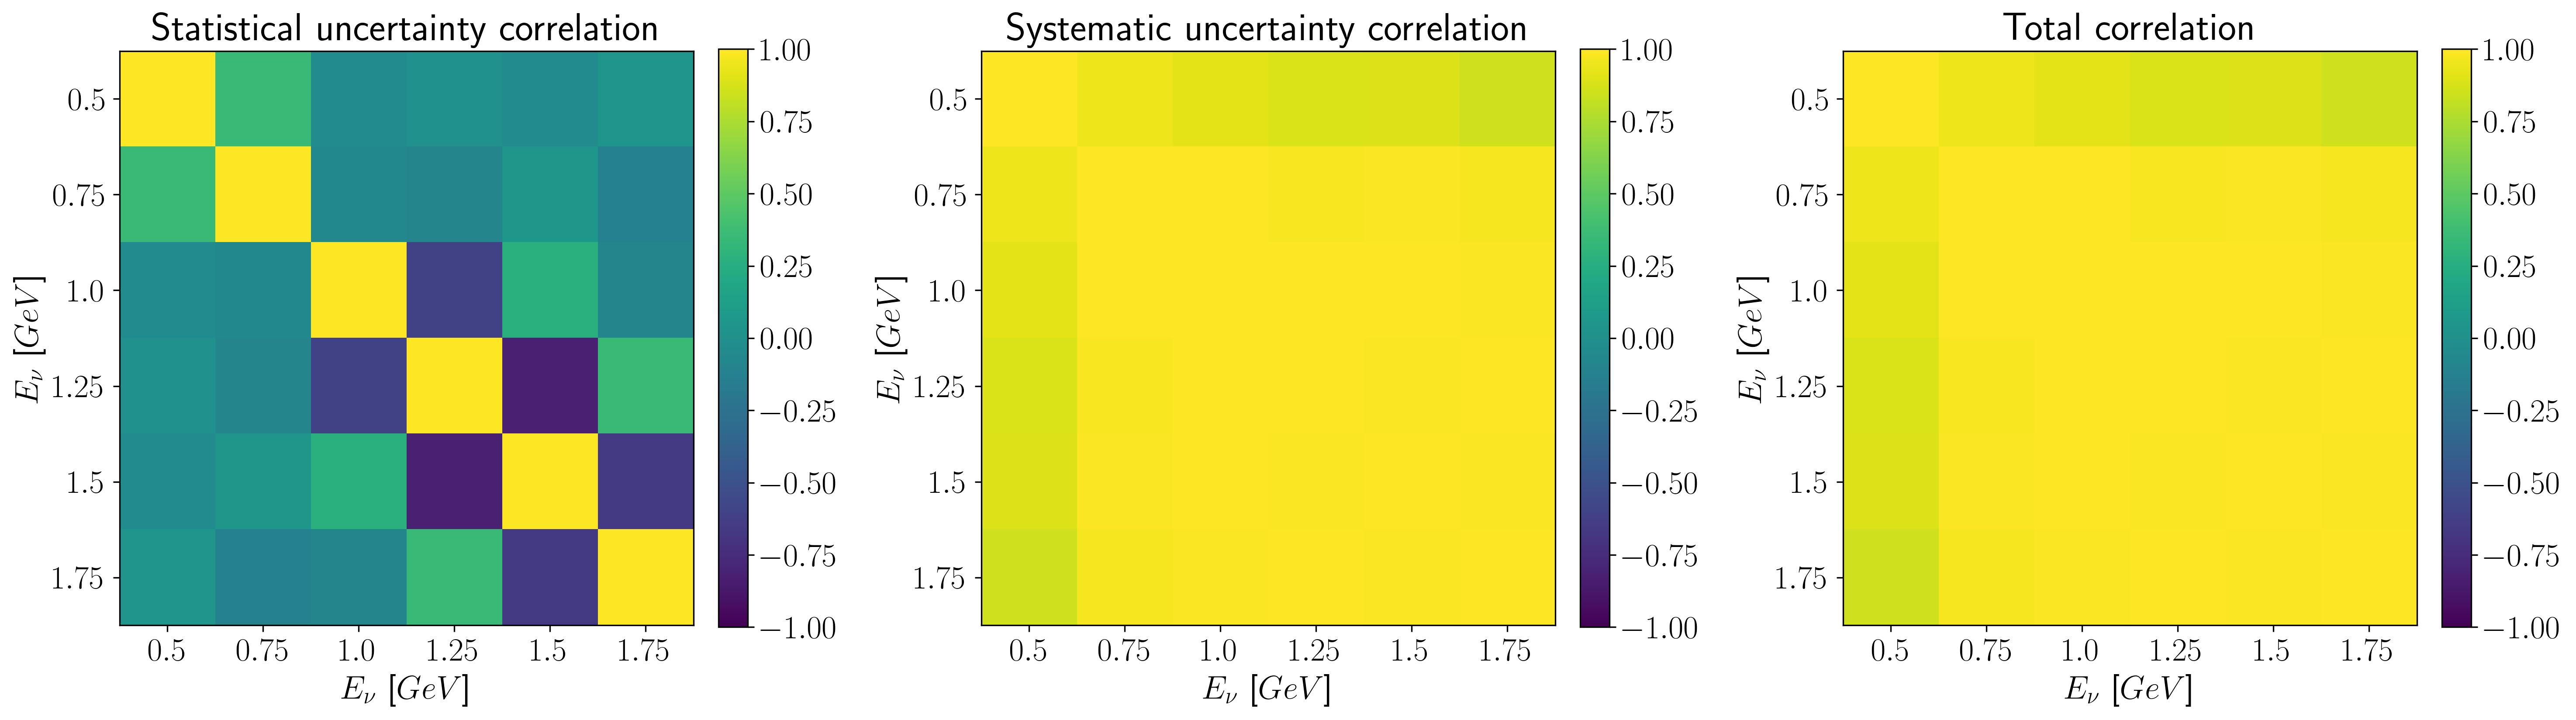

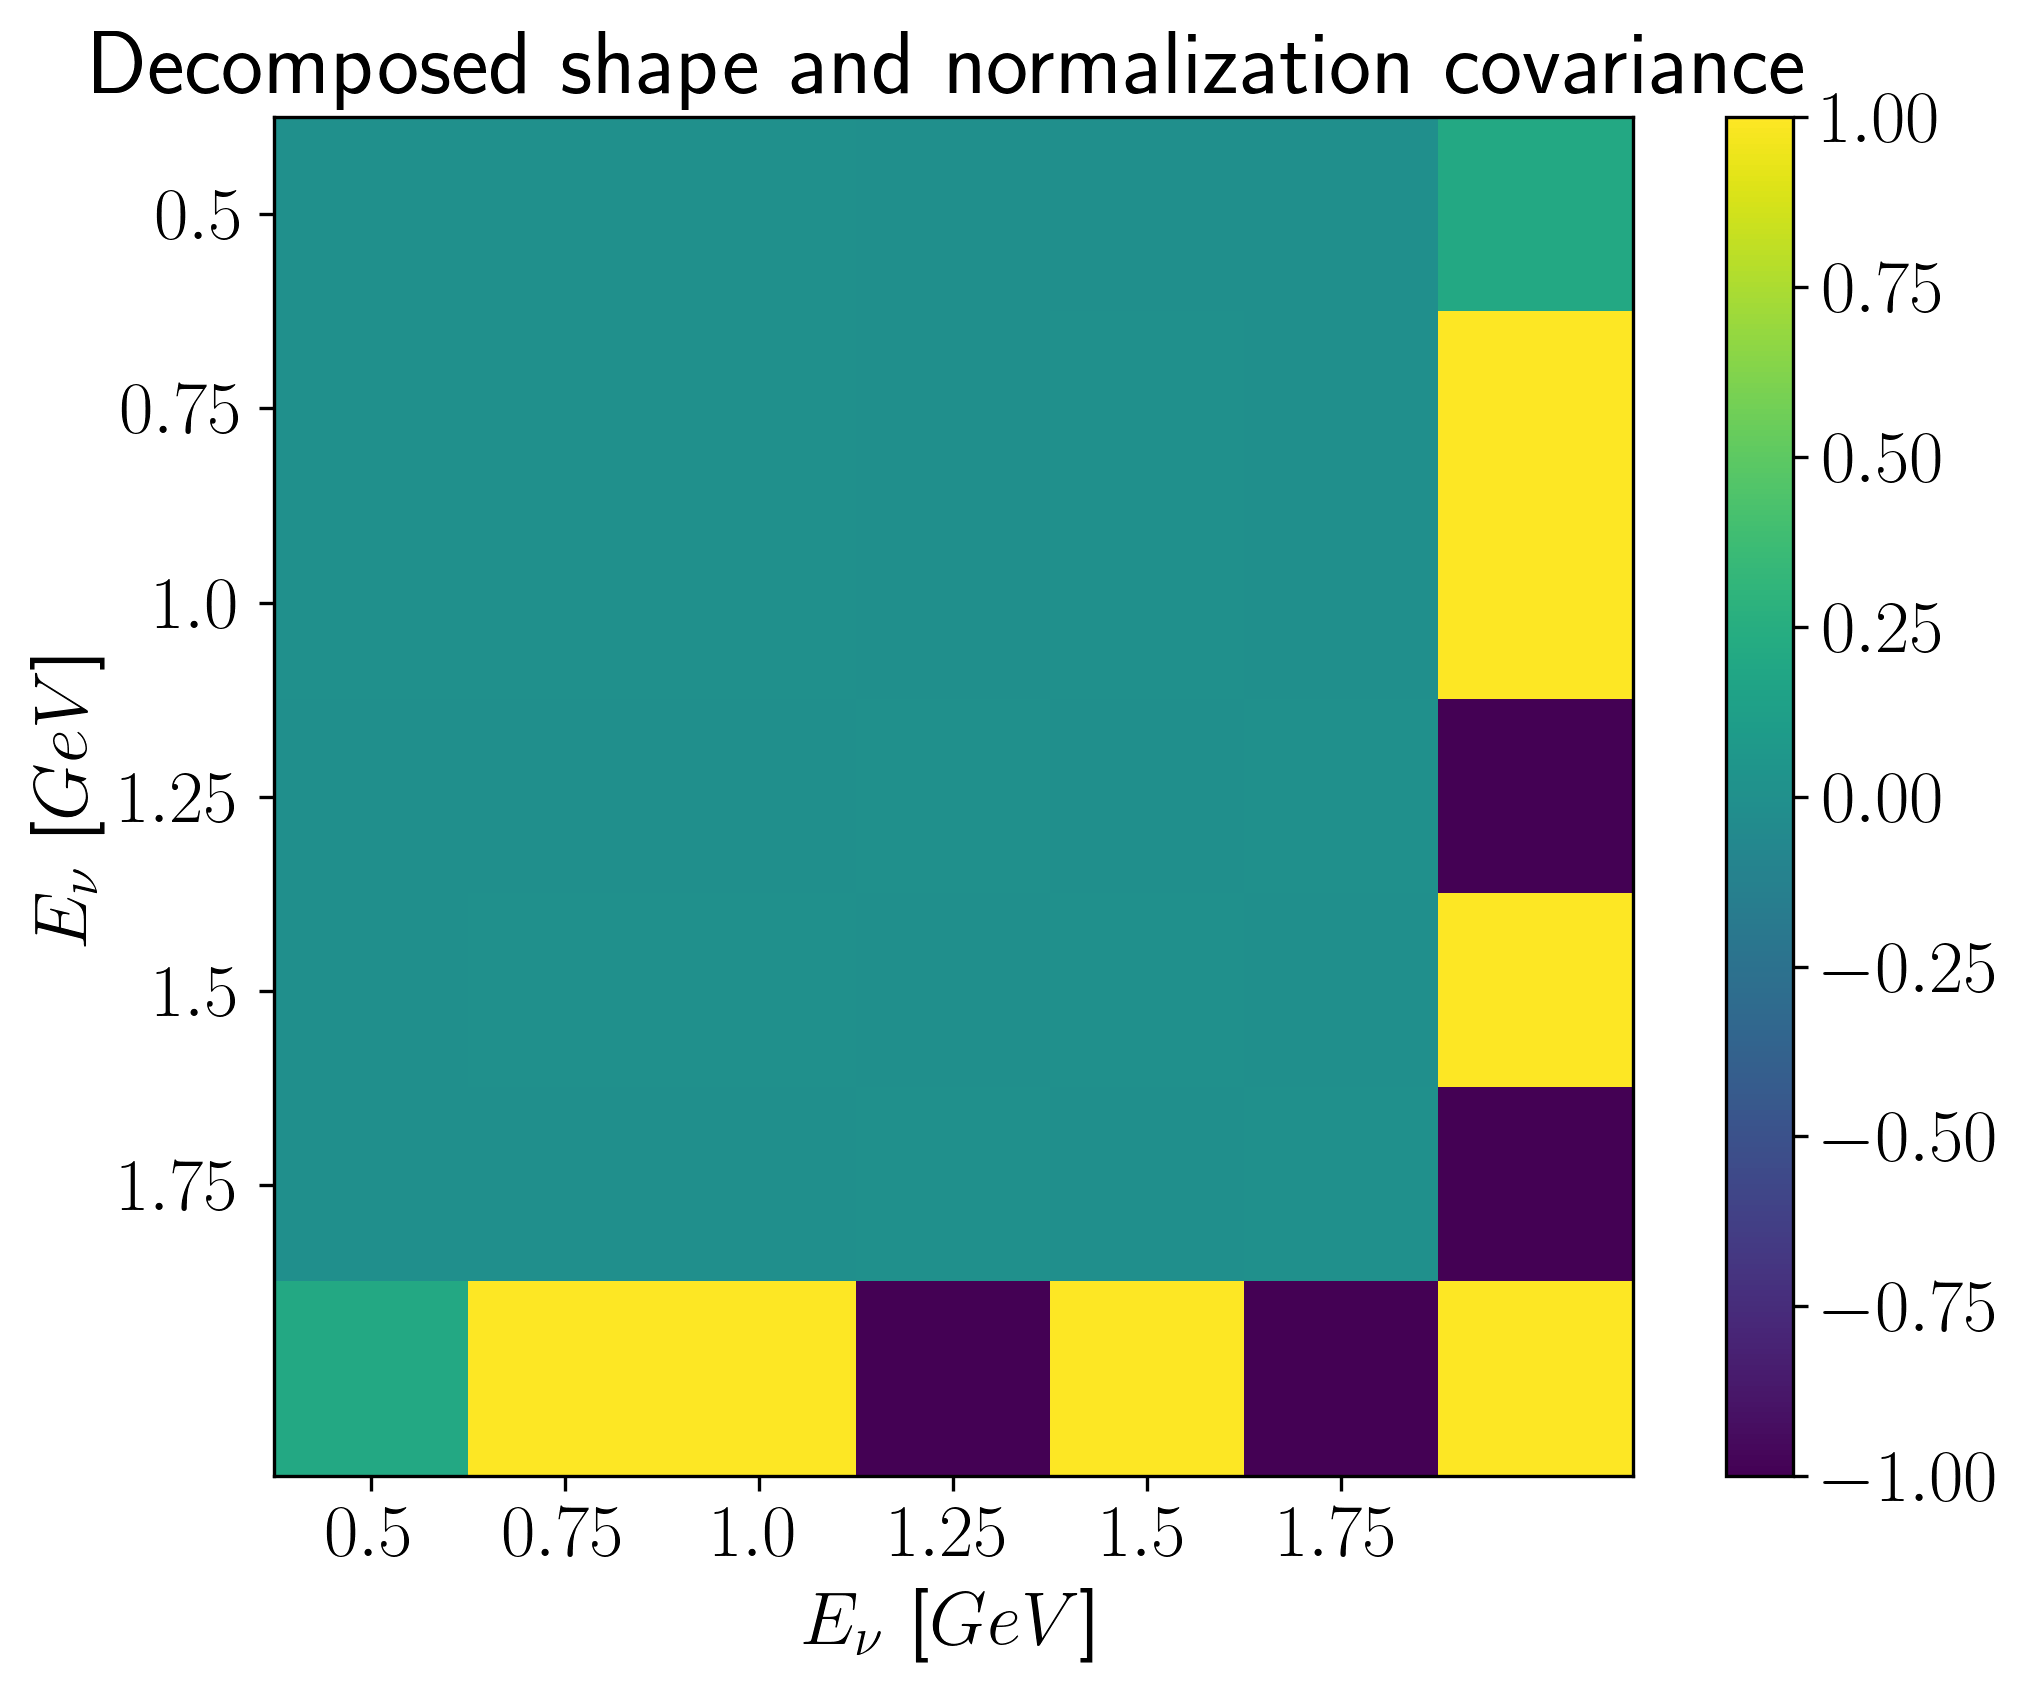

In [16]:
# Correlations
fig, axs = plt.subplots(1, 3, figsize=(20, 6), dpi=300)
fig.set_facecolor('white')

results = [stat_results,sys_results]
covariances = []
for i in range(2):
    covariance = np.cov(results[i][:-1,:-1])
    covariances.append(covariance)
    corrcoef = np.corrcoef(results[i][:-1,:-1])
    plt.sca(axs[i])
    im = plt.imshow(corrcoef)
    ticks = np.arange(len(energies)-1)
    plt.xticks(ticks, ["$"+str(energies[i])+"$" for i in ticks])
    plt.yticks(ticks, ["$"+str(energies[i])+"$" for i in ticks])
    res_string = "Statistical"
    if i==1:
        res_string = "Systematic"
    plt.title(res_string+" uncertainty correlation")
    plt.xlabel("$E_{\\nu}$ [$GeV$]")
    plt.ylabel("$E_{\\nu}$ [$GeV$]")
    plt.colorbar(im,fraction=0.046, pad=0.04)
    plt.clim(-1,1)

plt.sca(axs[2])
covariance_matrix = np.array(covariances).sum(axis=0)
sqrt_diagonal = np.sqrt(np.diag(covariance_matrix))
correlation_matrix = covariance_matrix / (sqrt_diagonal[:, None] * sqrt_diagonal[None, :])
im = plt.imshow(correlation_matrix)
ticks = np.arange(len(energies)-1)
plt.xticks(ticks, ["$"+str(energies[i])+"$" for i in ticks])
plt.yticks(ticks, ["$"+str(energies[i])+"$" for i in ticks])
res_string = "Total"
plt.title(res_string+" correlation")
plt.xlabel("$E_{\\nu}$ [$GeV$]")
plt.ylabel("$E_{\\nu}$ [$GeV$]")
plt.colorbar(im,fraction=0.046, pad=0.04)
plt.clim(-1,1)
plt.tight_layout()
plt.show()

# Decomposed covariance
figure(figsize=(8, 6), dpi=300)
plt.gcf().set_facecolor('white')
deco_cov = np.cov(sys_results_normed.T)
ticks = np.arange(len(energies)-1)
plt.xticks(ticks, ["$"+str(energies[i])+"$" for i in ticks])
plt.yticks(ticks, ["$"+str(energies[i])+"$" for i in ticks])
plt.title("Decomposed shape and normalization covariance")
plt.xlabel("$E_{\\nu}$ [$GeV$]")
plt.ylabel("$E_{\\nu}$ [$GeV$]")
plt.imshow(deco_cov)
plt.colorbar()
plt.clim(-1,1)